In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

2023-03-09 11:01:07.337081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Import Data

In [ ]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

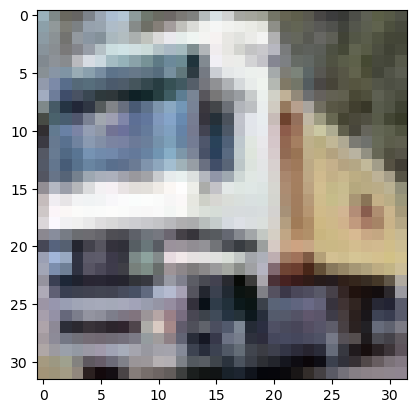

In [ ]:
plt.imshow(X_train[1])

### Normalize & Reshape Data

In [ ]:
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

X_train_flat = np.reshape(X_train, (50000, 3072))
X_test_flat = np.reshape(X_test, (10000, 3072))


### Accuracy Function

In [ ]:
def evaluate_acc(yh, y):
    if len(y) != len(yh):
        print("Lists must be the same length")
        return 0
    
    totalCorrect=0
    for i in range(0, len(y)):
        if y[i] == yh[i]:
            totalCorrect += 1
    return totalCorrect / len(y)

### Activation Functions

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))

Relu = lambda x: np.maximum(0,x)
relu_derivative = lambda x: np.where(x > 0, 1, 0)

Leaky_Relu = lambda x: max(0,x) + .01*min(0,x) 
leakyrelu_derivative = lambda x, alpha=0.01: np.where(x > 0, 1, alpha)

### Softmax Function

In [ ]:
softmax = lambda x: np.exp(x - np.max(x, axis=1, keepdims=True)) / np.sum(np.exp(x - np.max(x, axis=1, keepdims=True)), axis=1, keepdims=True)

### Perceptron - No hidden layers

In [ ]:
class Perceptron:
    
    def __init__(self, add_bias=True, max_iters=10, record_updates=False, learning_rate=0.001, num_categories=10):
        self.max_iters = max_iters
        self.add_bias = add_bias
        self.record_updates = record_updates
        self.learning_rate = learning_rate
        self.num_categories = num_categories
        self.w = []
        self.b = []
        self.errors = []
        if record_updates:
            self.w_hist = [] # records the weight 
            self.n_hist = [] # records the data-point selected
    
    def one_hot(self, y, num_categories):
        y_hot = np.zeros((y.shape[0], num_categories))
        y_hot[np.arange(y.shape[0]), y] = 1
        return y_hot
    
    def softmax(self, arr):
        top = np.exp(arr)
        bottom = np.sum(top, axis=1, keepdims=True)
        return top / bottom
    
    def forward(self, x):
        temp = np.dot(x, self.w)
        if self.add_bias:
            temp = temp + self.b
        return self.softmax(temp)
    
    def backprop(self, x, y, yh, y_hot):
        dW = np.dot(x.T, yh - y_hot)
        db = np.sum(yh - y_hot, axis=0, keepdims=True)
       
        self.w -= self.learning_rate * dW
        self.b -= self.learning_rate * db
    
    def predict(self, x_test):
        forward_res = self.forward(x_test)
        y_pred = np.argmax(forward_res, axis=1)
        return y_pred
    
    def weights(self):
        print(self.w)
        return self.w
    
    def cross_entropy(self, yh, y):
        n = yh.shape[0]
        return -np.sum(np.log(yh[np.arange(n), y])) / n
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def fit(self, x, y):
        
        if x.ndim == 1:
            # convert list to column i.e: [1,2,3] to [[1],[2],[3]]
            x = x[:, None]    
        
        # Initialize Weights
        self.w = np.zeros((x.shape[1], self.num_categories))
        
        # Initialize Bias
        self.b = np.zeros((1, self.num_categories))
        
        # One hot encoding for multiclass
        y_hot = self.one_hot(y, self.num_categories)
        
        t = 0
        
        change = True                            
        while t < self.max_iters:
            for n in np.random.permutation(x.shape[0]):
                
                yh = self.forward(x)
                
                if (t % (self.max_iters / 10) == 0):
                    loss = self.cross_entropy(yh, y)
                    self.errors.append(loss)
#                     print("Loss: ", loss)
                    
                self.backprop(x, y, yh, y_hot)
                
                t += 1
                if t >= self.max_iters:
                    break
            t += 1
        return self

### MLP - One hidden layer

In [ ]:
class MLP:
    
    def __init__(self, M=256, activation_function=Relu, activation_function_derivative= relu_derivative):
        self.M = M
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative 
        
    def fit(self, x, y, optimizer):
        N, D = x.shape
        def gradient(x, y, params):
            v, w = params
            z = self.activation_function(np.dot(x, v)) 
            yh = softmax(np.dot(z, w)) 
            dy = yh - y 
            dw = np.dot(z.T, dy)/N 
            dz = np.dot(dy, w.T) * self.activation_function_derivative(z) 
            dv = np.dot(x.T, dz)/N 
            dparams = [dv, dw]
            return dparams
        
        w = np.random.randn(self.M, y.shape[1]) * .01
        v = np.random.randn(D,self.M) * .01
        params0 = [v, w]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        v, w = self.params
        z = self.activation_function(np.dot(x, v)) 
        yh = softmax(np.dot(z, w)) 
        return yh

### MLP - Two hidden layers

In [ ]:
class MLP_2_Hidden_layer:
    
    def __init__(self, M1=256, M2=256, activation_function=Relu, activation_function_derivative= relu_derivative):
        self.M1 = M1
        self.M2 = M2
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative 
        
    def fit(self, x, y, optimizer):
        N, D = x.shape
        def gradient(x, y, params):
            v1, v2, w = params
            z1 = self.activation_function(np.dot(x, v1)) # N x M1
            z2 = self.activation_function(np.dot(z1, v2)) # N x M2
            yh = softmax(np.dot(z2, w)) 
            dy = yh - y 
            dw = np.dot(z2.T, dy)/N 
            dz2 = np.dot(dy, w.T) * self.activation_function_derivative(z2) # N x M2
            dz1 = np.dot(dz2, v2.T) * self.activation_function_derivative(z1) # N x M1
            dv2 = np.dot(z1.T, dz2)/N # M1 x M2
            dv1 = np.dot(x.T, dz1)/N # D x M1
            dparams = [dv1, dv2, dw]
            return dparams
        
        w = np.random.randn(self.M2, y.shape[1]) * .01
        v1 = np.random.randn(D,self.M1) * .01
        v2 = np.random.randn(self.M1,self.M2) * .01
        params0 = [v1, v2, w]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = self.activation_function(np.dot(x, v1)) # N x M1
        z2 = self.activation_function(np.dot(z1, v2)) # N x M2
        yh = softmax(np.dot(z2, w)) 
        return yh

### Gradient Descent Class for MLP's

In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params

### MLP 2 hidden layers -  L1 Regularization

In [ ]:
class MLP_L1:
    
    def __init__(self, M1=256, M2=256, activation_function=Relu, activation_function_derivative= relu_derivative, l1_penalty=0.):
        self.M1 = M1
        self.M2 = M2
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
        self.l1_penalty = l1_penalty
        
    def fit(self, x, y, optimizer):
        N, D = x.shape
        def gradient(x, y, params):
            v1, v2, w = params
            z1 = self.activation_function(np.dot(x, v1)) # N x M1
            z2 = self.activation_function(np.dot(z1, v2)) # N x M2
            yh = softmax(np.dot(z2, w)) 
            dy = yh - y 
            dw = np.dot(z2.T, dy)/N + self.l1_penalty * np.sign(w) 
            dz2 = np.dot(dy, w.T) * self.activation_function_derivative(z2) # N x M2
            dz1 = np.dot(dz2, v2.T) * self.activation_function_derivative(z1) # N x M1
            dv2 = np.dot(z1.T, dz2)/N + self.l1_penalty * np.sign(v2) # M1 x M2
            dv1 = np.dot(x.T, dz1)/N + self.l1_penalty * np.sign(v1) # D x M1
            dparams = [dv1, dv2, dw]
            return dparams
        
        w = np.random.randn(self.M2, y.shape[1]) * .01
        v1 = np.random.randn(D,self.M1) * .01
        v2 = np.random.randn(self.M1,self.M2) * .01
        params0 = [v1, v2, w]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = self.activation_function(np.dot(x, v1)) # N x M1
        z2 = self.activation_function(np.dot(z1, v2)) # N x M2
        yh = softmax(np.dot(z2, w)) 
        return yh

### MLP 2 hidden layers -  L2 Regularization

In [ ]:
class MLP_L2:
    
    def __init__(self, M1=256, M2=256, activation_function=Relu, activation_function_derivative= relu_derivative, l2_penalty=0.):
        self.M1 = M1
        self.M2 = M2
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
        self.l2_penalty = l2_penalty
        
    def fit(self, x, y, optimizer):
        N, D = x.shape
        def gradient(x, y, params):
          v1, v2, w = params
          z1 = self.activation_function(np.dot(x, v1)) # N x M1
          z2 = self.activation_function(np.dot(z1, v2)) # N x M2
          yh = softmax(np.dot(z2, w))
          dy = yh - y 
          dw = np.dot(z2.T, dy)/N + self.l2_penalty * w  
          dz2 = np.dot(dy, w.T) * self.activation_function_derivative(z2) # N x M2
          dz1 = np.dot(dz2, v2.T) * self.activation_function_derivative(z1) # N x M1
          dv2 = np.dot(z1.T, dz2)/N + self.l2_penalty * v2 # M1 x M2 
          dv1 = np.dot(x.T, dz1)/N + self.l2_penalty * v1 # D x M1 
          dparams = [dv1, dv2, dw]
          return dparams

        
        w = np.random.randn(self.M2, y.shape[1]) * .01
        v1 = np.random.randn(D,self.M1) * .01
        v2 = np.random.randn(self.M1,self.M2) * .01
        params0 = [v1, v2, w]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = self.activation_function(np.dot(x, v1)) # N x M1
        z2 = self.activation_function(np.dot(z1, v2)) # N x M2
        yh = softmax(np.dot(z2, w)) 
        return yh

### Question 1 & Finding HyperParameters

In order to compare MLP's with different depths, we first need to find the optimal learning rate and max iterations to achieve optimal performance. We choose not to use the same learning rates and epochs for all three models because deeper networks require different parameters to converge properly than shallower networks. Thus we will approximate the oprimal hyperparameters below.

#### Perceptron Optimal Hyperparameters

For the sake of time and computing power, the max iterations for the perceptron is limited to 100. We have run some tests with more iterations and have found that the accuracy is typically better; however, for the scope of this assignment we found 100 iterations to be sufficient to reflect the behaviours of the models.

From the experiments below we found the best learning rate to be approximately: 0.0000005



In [ ]:
accuracy_arr = []
learning_rates = [0.00000001, 0.0000001, 0.0000005, 0.000001, 0.00001]

for lr in learning_rates:
    model = Perceptron(record_updates=True, num_categories=10, learning_rate=lr,  max_iters=100)
    # May need to flatten y_train
    model.fit(X_train_flat, y_train[:, 0])
    
    yh = model.predict(X_test_flat)
    y = y_test
    
    accuracy = evaluate_acc(y,yh)
    print("accuracy: ", accuracy)
    
    accuracy_arr.append(accuracy)
    

accuracy:  0.1492
accuracy:  0.2968
accuracy:  0.3235
accuracy:  0.2866
accuracy:  0.1624


Text(0, 0.5, 'Accuracy')

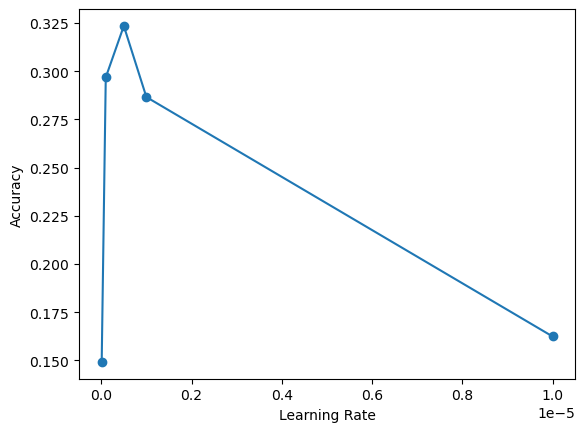

In [ ]:
plt.plot(learning_rates, accuracy_arr, marker='o')
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")

#### One Hidden Layer MLP Optimal Hyperparameters

In order to test the accuracy different learning rates, we had to limit the number of epochs to 20 to keep the computations within a reasonable time frame.

From the experiments below we found the best learning rate to be approximately: 0.1

In [ ]:
# Convert labels to one-hot encoding
enc = OneHotEncoder(categories='auto')
y_train_hot = enc.fit_transform(y_train.reshape(-1,1)).toarray()
y_test_hot = enc.transform(y_test.reshape(-1,1)).toarray()

# Flatten the images
x_train = X_train.reshape(X_train.shape[0], -1)  
x_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_arr = []
learning_rates = [0.0001, 0.001,.05, .1, .5]

for lr in learning_rates:
    model = MLP(M=256)
    optimizer = GradientDescent(learning_rate=lr, max_iters=50)
    y_pred = model.fit(x_train, y_train_hot, optimizer).predict(x_test)
    
    # Convert one-hot encoded y_test back to class labels
    y_test_labels = np.argmax(y_test, axis=1)

    # Convert MLP predictions to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred_labels)
    
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    accuracy_arr.append(accuracy)

KeyboardInterrupt: 

In [ ]:
plt.plot(learning_rates, accuracy_arr, marker='o')
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")

#### Two Hidden Layer MLP Optimal Hyperparameters¶
In order to test the accuracy different learning rates, we had to limit the number of epochs to 20 to keep the computations within a reasonable time frame.

From the experiments below we found the best learning rate to be approximately: 0.5

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_arr = []
learning_rates = [0.05, .1, .5, 1]

for lr in learning_rates:
    model = MLP_2_Hidden_layer(M1=256, M2=256)
    optimizer = GradientDescent(learning_rate=lr, max_iters=50)
    y_pred = model.fit(x_train, y_train_hot, optimizer).predict(x_test)
    
    # Convert one-hot encoded y_test back to class labels
    y_test_labels = np.argmax(y_test, axis=1)

    # Convert MLP predictions to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred_labels)
    
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    accuracy_arr.append(accuracy)

In [ ]:
plt.plot(learning_rates, accuracy_arr, marker='o')
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")

### Question 1
By implementing different MLP models with 0,1 & 2 hidden layers we were able to report the effects of linearity and network depth. Our hightest achieved accuracy for a perceptron was around 29%, one hidden layer  and two hidden layers. The perceptron seems to have a lower accuracy which is partially do to its limitations of only modelling linear relationships. The MLPs with hidden layers; however, have a non-linear activation functions, in this case ReLU. Based on our understanding of neural networks learned in class these results are as expected as more hidden layers allows the model to model more complex relationships with the training data. 


In [ ]:
# Convert labels to one-hot encoding
enc = OneHotEncoder(categories='auto')
y_train_hot = enc.fit_transform(y_train.reshape(-1,1)).toarray()
y_test_hot = enc.transform(y_test.reshape(-1,1)).toarray()

# Flatten the images
x_train = X_train.reshape(X_train.shape[0], -1)  
x_test = X_test.reshape(X_test.shape[0], -1)

### Question 2

Activation functions needed for question 2

In [ ]:
Relu = lambda x: np.maximum(0,x)
Leaky_Relu = lambda x: np.maximum(0,x) + .01*np.minimum(0,x)
relu_derivative = lambda x: np.where(x > 0, 1, 0)
leakyrelu_derivative = lambda x, alpha=0.01: np.where(x > 0, 1, alpha)
tanh = lambda z: np.tanh(z)
tanh_derivative = lambda z: 1 - np.tanh(z)**2

For this question, MLP model with double layer has been tested with the above activation functions and the results recorded on by one for plotting reasons. Below demonstrates how these datas are collected

### i) RELU

In [ ]:
model = MLP(activation_function=Relu, activation_function_derivative= relu_derivative)
optimizer=GradientDescent(learning_rate=.1, max_iters=1)
training_relu= model.fit(x_train, y_train_hot, optimizer)
y_predm_relu = training_relu.predict(x_test) 

**Training Data**

In [ ]:
y_predm_relu_tr = training_relu.predict(x_train) 

y_test_labels = np.argmax(y_train_hot, axis=1)

y_pred_labels_tr = np.argmax(y_predm_relu_tr, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels_tr)
print("Accuracy: {:.2f}%".format(accuracy * 100))

**Test Data**

In [ ]:
y_predm_relu_t = training_relu.predict(x_test) 

y_pred_labels_t = np.argmax(y_predm_relu_t, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels_t)
print("Accuracy: {:.2f}%".format(accuracy * 100))

ii) TANH

In [ ]:
model = MLP(activation_function=tanh, activation_function_derivative= tanh_derivative)
optimizer = GradientDescent(learning_rate=.1, max_iters=1)
training_tan = model.fit(x_train, y_train_hot, optimizer)
y_predm_tan = training_tan.predict(x_test) 

**Training Data**

In [ ]:
y_predm_tan_tr = training_tan.predict(x_train) 

y_test_labels_tan = np.argmax(y_train_hot, axis=1)

y_pred_labels_tan_tr = np.argmax(y_predm_tan_tr, axis=1)

accuracy = accuracy_score(y_test_labels_tan, y_pred_labels_tan_tr)
print("Accuracy: {:.2f}%".format(accuracy * 100))

**Test Data**

In [ ]:
y_predm_tan_t = training_tan.predict(x_test) 

y_pred_labels_tan_t = np.argmax(y_predm_tan_t, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels_tan_t)
print("Accuracy: {:.2f}%".format(accuracy * 100))

iii) LEAKY RELU

In [ ]:
model = MLP(activation_function=Leaky_Relu, activation_function_derivative= leakyrelu_derivative)
optimizer2=GradientDescent(learning_rate=.1, max_iters=1)
training_lrelu = model.fit(x_train, y_train_hot, optimizer)
y_predm_lrelu = training_tan.predict(x_test) 

**Training Data**

In [ ]:
y_predm_lrelu_tr = training_lrelu.predict(x_train) 

y_test_labels_lrelu = np.argmax(y_train_hot, axis=1)

y_pred_labels_lrelu_tr = np.argmax(y_predm_lrelu_tr, axis=1)

accuracy = accuracy_score(y_test_labels_lrelu, y_pred_labels_lrelu_tr)
print("Accuracy: {:.2f}%".format(accuracy * 100))

**Test Data**

In [ ]:
y_predm_lrelu_t = training_lrelu.predict(x_test) 

y_pred_labels_lrelu_t = np.argmax(y_predm_lrelu_t, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels_lrelu_t)
print("Accuracy: {:.2f}%".format(accuracy * 100))

After running all of these with epochs 1,10,500,1000, and 3000 we got the following data respecting to each model with different activcation function

In [ ]:
tanh_train_acc = [0.1084, 0.1552, 0.3084, 0.3679, 0.4151]
tanh_test_acc = [0.0895, 0.1066, 0.2721, 0.3538, 0.4044]
relu_train_acc = [0.1108, 0.1552, 0.3084, 0.3538, 0.5127]
relu_test_acc = [0.1007, 0.1561, 0.31, 0.4014, 0.4875]
leaky_relu_train_acc=[0.0903,0.1338,0.3173, 0.3910, 0.4821 ]
leaky_relu_test_acc=[0.0941,0.1316,0.3145,0.3942, 0.4787 ]

epochs = [1,10,500,1000,3000]

Plotting the accuracy comperance of three models with different activation functions

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].plot(epochs, tanh_train_acc, label="tanh")
axes[0].plot(epochs, relu_train_acc, label="ReLU")
axes[0].plot(epochs, leaky_relu_train_acc, label="LeakyReLU")
axes[0].set_title("Training Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].plot(epochs, tanh_test_acc, label="tanh")
axes[1].plot(epochs, relu_test_acc, label="ReLU")
axes[1].plot(epochs, leaky_relu_test_acc, label="LeakyReLU")
axes[1].set_title("Testing Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.show()

### Question 3

Firstly we conducted an experiment get the optimal strengths for l1 and l2 regularization. So we conducted an experiment between two models one with l1 and the other with l2 regularization while changing the regularization strength and keeping epoch to 10.

In [ ]:
#with 10 epochs
l1_strengths = [0.01, 0.1, 1, 10]
l2_strengths = [0.01, 0.1, 1, 10]
optimizer=GradientDescent(learning_rate=.1, max_iters=10)

train_accs_l1_st = []
test_accs_l1_st = []
train_accs_l2_st = []
test_accs_l2_st = []

for l1_strength in l1_strengths:
    for l2_strength in l2_strengths:
        # Train MLP_L1 with l1_strength
        mlp_l1 = MLP_L1(l1_penalty=l1_strength)
        mlp_l1.fit(x_train, y_train_hot, optimizer)
        y_train_pred_l1 = mlp_l1.predict(x_train)
        y_test_pred_l1 = mlp_l1.predict(x_test)
        train_acc_l1_st = accuracy_score(np.argmax(y_train_hot, axis=1), np.argmax(y_train_pred_l1, axis=1))
        test_acc_l1_st = accuracy_score(y_test, np.argmax(y_test_pred_l1, axis=1))
        train_accs_l1_st.append(train_acc_l1_st)
        test_accs_l1_st.append(test_acc_l1_st)
        
        # Train MLP_L2 with l2_strength
        mlp_l2 = MLP_L2(l2_penalty=l2_strength)
        mlp_l2.fit((x_train, y_train_hot, optimizer)
        y_train_pred_l2 = mlp_l2.predict(x_train)
        y_test_pred_l2 = mlp_l2.predict(x_test)
        train_acc_l2_st = accuracy_score(np.argmax(y_train_hot, axis=1), np.argmax(y_train_pred_l2, axis=1))
        test_acc_l2_st = accuracy_score(y_test, np.argmax(y_test_pred_l2, axis=1))
        train_accs_l2_st.append(train_acc_l2_st)
        test_accs_l2_st.append(test_acc_l2_st)


Pltting the results

In [ ]:
plt.plot(l2_strengths, train_accs_l1_st[:4], 'ro-', label='MLP with L1 Regularization')
plt.plot(l2_strengths, train_accs_l2_st[:4], 'bo-', label='MLP with L2 Regularization')
plt.xscale('log')
plt.xlabel('Regularization strength')
plt.ylabel('Train accuracy')
plt.title('Train accuracies vs Regularization strength')
plt.legend()
plt.show()

# plot test accuracies
plt.plot(l2_strengths, test_accs_l1_st[:4], 'ro-', label='MLP with L1 Regularization')
plt.plot(l2_strengths, test_accs_l2_st[:4], 'bo-', label='MLP with L2 Regularization')
plt.xscale('log')
plt.xlabel('Regularization strength')
plt.ylabel('Test accuracy')
plt.title('Test accuracies vs Regularization strength')
plt.legend()
plt.show()

So in the end we find out that best value for l1_strength is 1 and 0l1 for l2_strength

Then we compare the accuracy of model without regularization and the model with l1 regularization and model with l2 regularization with different number of epochs 

In [ ]:
l1_strength = 1
l2_strength = 0.1


train_accs_l1 = []
test_accs_l1 = []
train_accs_l2 = []
test_accs_l2 = []
train_accs_no_reg = []
test_accs_no_reg = []
epochs = [10, 20, 30, 40, 50]

for epoch in epochs:
    # Train MLP_L1 with l1_strength
    mlp_l1 = MLP_L1(l1_penalty=l1_strength)
    mlp_l1.fit(x_train, Y_train, optimizer=GradientDescent2(learning_rate=.001, max_iters=epoch))
    y_train_pred_l1 = mlp_l1.predict(x_train)
    y_test_pred_l1 = mlp_l1.predict(x_test)
    train_acc_l1 = accuracy_score(np.argmax(Y_train, axis=1), np.argmax(y_train_pred_l1, axis=1))
    test_acc_l1 = accuracy_score(y_test, np.argmax(y_test_pred_l1, axis=1))
    train_accs_l1.append(train_acc_l1)
    test_accs_l1.append(test_acc_l1)

    # Train MLP_L2 with l2_strength
    mlp_l2 = MLP_L2(l2_penalty=l2_strength)
    mlp_l2.fit(x_train, Y_train, optimizer=GradientDescent2(learning_rate=.001, max_iters=epoch))
    y_train_pred_l2 = mlp_l2.predict(x_train)
    y_test_pred_l2 = mlp_l2.predict(x_test)
    train_acc_l2 = accuracy_score(np.argmax(Y_train, axis=1), np.argmax(y_train_pred_l2, axis=1))
    test_acc_l2 = accuracy_score(y_test, np.argmax(y_test_pred_l2, axis=1))
    train_accs_l2.append(train_acc_l2)
    test_accs_l2.append(test_acc_l2)

    # Train MLP without regularization
    mlp_no_reg = MLP()
    mlp_no_reg.fit(x_train, Y_train, optimizer=GradientDescent2(learning_rate=.001, max_iters=epoch))
    y_train_pred_no_reg = mlp_no_reg.predict(x_train)
    y_test_pred_no_reg = mlp_no_reg.predict(x_test)
    train_acc_no_reg = accuracy_score(np.argmax(Y_train, axis=1), np.argmax(y_train_pred_no_reg, axis=1))
    test_acc_no_reg = accuracy_score(y_test, np.argmax(y_test_pred_no_reg, axis=1))
    train_accs_no_reg.append(train_acc_no_reg)
    test_accs_no_reg.append(test_acc_no_reg)


plotting the results

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs, train_accs_l1, label='L1')
plt.plot(epochs, train_accs_l2, label='L2')
plt.plot(epochs, train_accs_no_reg, label='No regularization')
plt.title('Training accuracy vs. epochs comparison between l1,l2 and no regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, test_accs_l1, label='L1')
plt.plot(epochs, test_accs_l2, label='L2')
plt.plot(epochs, test_accs_no_reg, label='No regularization')
plt.title('Test accuracy vs. epochs comparison between l1,l2 and no regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Question 4

In [ ]:
import time

## Training Two Layer MLP with unnormalized data
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

# Reshape the data for our model
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Create normalized training data
X_train_normalized = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test_normalized = (X_test - X_test.min()) / (X_test.max() - X_test.min())

optimizer = GradientDescent(learning_rate=0.1, max_iters=20)


start_time_un = time.time()
# Fitting with unnormalized data
MLP2 = MLP_2_Hidden_layer(M1=256, M2=256)
y_train_pred = MLP2.fit(X_train, y_train_hot, optimizer).predict(X_train)
y_test_pred = MLP2.predict(X_test)

y_train_pred_labels = np.argmax(y_train_pred, axis=1)
train_accuracy_un = accuracy_score(y_train, y_train_pred_labels)

y_test_pred_labels = np.argmax(y_test_pred, axis=1)
test_accuracy_un = accuracy_score(y_test, y_test_pred_labels)

end_time_un = time.time()


start_time_n = time.time()
# Fitting with normalized data
MLP2 = MLP_2_Hidden_layer(M1=256, M2=256)
y_train_pred = MLP2.fit(X_train_normalized, y_train_hot, optimizer).predict(X_train)
y_test_pred = MLP2.predict(X_test)

y_train_pred_labels = np.argmax(y_train_pred, axis=1)
train_accuracy_n = accuracy_score(y_train, y_train_pred_labels)

y_test_pred_labels = np.argmax(y_test_pred, axis=1)
test_accuracy_n = accuracy_score(y_test, y_test_pred_labels)
end_time_n = time.time()

elapsed_time_un = end_time_un - start_time_un
elapsed_time_n = end_time_n - start_time_n 

print(f"Elapsed time for unnormalized: {elapsed_time_un:.5f} seconds")
print(f"Elapsed time for normailized: {elapsed_time_n:.5f} seconds")

print("Unnormalized test accuracy: ", test_accuracy_un)
print("Unnormalized train accuracy: ",train_accuracy_un)

print("Normalized test accuracy: ", test_accuracy_n)
print("Normalized train accuracy: ",train_accuracy_n)





Elapsed time for unnormalized: 32.62960 seconds
Elapsed time for normailized: 57.12020 seconds
Unnormalized test accuracy:  0.1
Unnormalized train accuracy:  0.1
Normalized test accuracy:  0.1385
Normalized train accuracy:  0.13932


We found that using the same learning rate with unnormalized data results in an error and will cause errors in the fit function and result in the accuracy being 0.1 . This makes sense as the pixels in unnormalized data have different ranges, in this case 0-255 thus a new learning rate will need to accomodate. We experimented with different learning rates for unnormalized data and found the acccuracy to result in silimair.  

In [ ]:
import time

## Training Two Layer MLP with unnormalized data
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

# Reshape the data for our model
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Create normalized training data
X_train_normalized = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test_normalized = (X_test - X_test.min()) / (X_test.max() - X_test.min())

optimizer = GradientDescent(learning_rate=0.000001, max_iters=20)


start_time_un = time.time()
# Fitting with unnormalized data
MLP2 = MLP_2_Hidden_layer(M1=256, M2=256)
y_train_pred = MLP2.fit(X_train, y_train_hot, optimizer).predict(X_train)
y_test_pred = MLP2.predict(X_test)

y_train_pred_labels = np.argmax(y_train_pred, axis=1)
train_accuracy_un = accuracy_score(y_train, y_train_pred_labels)

y_test_pred_labels = np.argmax(y_test_pred, axis=1)
test_accuracy_un = accuracy_score(y_test, y_test_pred_labels)

end_time_un = time.time()

elapsed_time_un = end_time_un - start_time_un

rint("Unnormalized test accuracy: ", test_accuracy_un)
print("Unnormalized train accuracy: ",train_accuracy_un)
print(f"Elapsed time for unnormalized: {el_time_un:.5f} seconds")


NameError: name 'rint' is not defined

### Bonus

 We decided to try our model with mini-batch in order to shorten the training time and see if we still get good accuracy results. So we wanted to see the effects of different batch sizes to our double layer model, so we made an experiment to see the the effect of the batch size of our optimizer to the accuracy of our model.  We used batch sizes  of 32, 64, 128, 256, 512 and full batch.

Firstly below is the gradient descent with mini batch implementation

In [ ]:
class GradientDescent_MB:
    
    def __init__(self, learning_rate=0.001, max_iters=10000, epsilon=1e-8, batch_size=1):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        
    def run(self, gradient_fn, x, y, params):
        N = x.shape[0]
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            indices = np.random.choice(N, self.batch_size, replace=False)
            x_batch = x[indices]
            y_batch = y[indices]
            grad = gradient_fn(x_batch, y_batch, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params

First we test the batch sizes with 10 epochs on doube layered MLP model

In [ ]:
batch_sizes = [32, 64, 128, 256, 512, len(x_train)]

train_accs = []
test_accs = []

for batch_size in batch_sizes:
    mlp = MLP()
    optimizer = GradientDescent_MB(learning_rate=.1, max_iters=10, batch_size = batch_size)
    mlp.fit(x_train, Y_train,optimizer) 
    
    y_train_pred = mlp.predict(x_train)
    y_test_pred = mlp.predict(x_test)
    
    train_acc = accuracy_score(np.argmax(Y_train, axis=1), np.argmax(y_train_pred, axis=1))
    test_acc = accuracy_score(y_test, np.argmax(y_test_pred, axis=1))
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)


In [ ]:

plt.plot(batch_sizes, train_accs, '-o', label='train accuracy')
plt.xscale('log')
plt.xlabel('Batch size')
plt.ylabel('Accuracy')
plt.title('Train accuracy vs. batch size with 10 epochs')
plt.legend()
plt.show()

plt.plot(batch_sizes, test_accs, '-o', label='test accuracy')
plt.xscale('log')
plt.xlabel('Batch size')
plt.ylabel('Accuracy')
plt.title('Test accuracy vs. batch size with 10 epochs')
plt.legend()
plt.show()

Then we wanted to see what happens with larger epochs and we tested that below with 1000 epochs.

In [ ]:
batch_sizes = [32, 64, 128, 256, 512, len(x_train)]

train_accs = []
test_accs = []

for batch_size in batch_sizes:
    mlp = MLP()
    optimizer = GradientDescent_MB(learning_rate=.1, max_iters=1000, batch_size = batch_size)
    mlp.fit(x_train, Y_train,optimizer) 
    
    y_train_pred = mlp.predict(x_train)
    y_test_pred = mlp.predict(x_test)
    
    train_acc = accuracy_score(np.argmax(Y_train, axis=1), np.argmax(y_train_pred, axis=1))
    test_acc = accuracy_score(y_test, np.argmax(y_test_pred, axis=1))
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)

In [ ]:
plt.plot(batch_sizes, train_accs, '-o', label='train accuracy')
plt.xscale('log')
plt.xlabel('Batch size')
plt.ylabel('Accuracy')
plt.title('Train accuracy vs. batch size')
plt.legend()
plt.show()

plt.plot(batch_sizes, test_accs, '-o', label='test accuracy')
plt.xscale('log')
plt.xlabel('Batch size')
plt.ylabel('Accuracy')
plt.title('Test accuracy vs. batch size')
plt.legend()
plt.show()